# Text Classification mit XGBoost - Training with Stopwords

In [1]:
import numpy as np # for array, linear algebra
import pandas as pd # for data processing
import matplotlib as mpl  # to visualize data
import matplotlib.pyplot as plt # to crreate stat and visualize data
import matplotlib.colors as mcolors # to visualize colors
import seaborn as sns # to visualize data
from sklearn.feature_extraction.text import TfidfVectorizer # to transfrom the text into numbers
from sklearn.metrics import * # to calculate the metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import pickle
import xgboost as xgb# used model

pd.set_option('display.max_colwidth', None) # setting to show full text content

In [2]:
# load datasets
train_stop = pd.read_csv('../../../Data-Preparation/sentiment140/traindata_with_stopwords_preprocessed.csv')
dev_stop = pd.read_csv('../../../Data-Preparation/sentiment140/devdata_with_stopwords_preprocessed.csv')

In [3]:
train_stop.head()

,Text,Ground_Truth_Label,target
0,@ddlovato wow Not wise of your fear of the elevators incredible! i love you demi !,negative,0
1,"@rimamelati hahaha! i'm so so bored. what are you doing? haha, the plane crash is so so scary",negative,0
2,"@BrendaSanDiego Sure, i'm following you now",positive,4
3,"@yum9me does your itunes say that you can download OS3 yet, because mine says my OS is up to date",negative,0
4,@PetiteAntoin my mom's French Mauritian and I can't speak French Good luck learning it,negative,0


In [4]:
# load the vectorizer from file
with open('../../../Data-Preparation/sentiment140/tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
print(loaded_vectorizer)

TfidfVectorizer()


In [5]:
# extraction of feature and labels
train_stop['target'] = train_stop['target'].replace(4,1)
X_train_stop = train_stop.drop(['target', 'Ground_Truth_Label'], axis=1).copy()
Y_train_stop = train_stop['target'].copy()

dev_stop['target'] = dev_stop['target'].replace(4,1)
X_dev_stop = dev_stop.drop(['target', 'Ground_Truth_Label'], axis=1).copy()
Y_dev_stop = dev_stop['target'].copy()


### Vectorization of the Data

Vectorization is a necessary step, as machine learning models are only capable of processing numerical data. 

In [6]:
# astype(str) is necesarry 
X_training_stop = loaded_vectorizer.transform(X_train_stop['Text'].astype(str))
X_devset_stop = loaded_vectorizer.transform(X_dev_stop['Text'].astype(str))


### without Hyperparametertuning

In [7]:
model = xgb.XGBClassifier(n_jobs = -1)
model.fit(X_training_stop, Y_train_stop)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
predictions_stop = model.predict(X_training_stop)

In [9]:
accuracy = accuracy_score(Y_train_stop, predictions_stop)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 76.67%


### with Hyperparametertuning

It was actively decided against the use of automated searches for the best hyperparameters, as this would require too much computational effort due to the size of the data set. We were unable to provide this computing power. 

manual tuning using the parameters listed for better accuracy on : https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [10]:
#accuracy 75.7%, time for fit: 43s
# # use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
# )

#accuracy 72%, time for fit: 7s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     max_depth=2
# )

#accuracy 73%, time for fit: 11s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     max_depth=3
# )

#accuracy 74.7%, time for fit: 21s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     max_depth=4
# )

#accuracy 75%, time for fit: 34s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     max_depth=5
# )

#accuracy 75.7%, time for fit: 54s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     max_depth=6
# )

#accuracy 76.1%, time for fit: 54s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     max_depth=7
# )

#accuracy 76.3%, time for fit: 2m 25s
# use tree-based models as boosters
model2 = xgb.XGBClassifier(
    boosting_type='dart',
    max_depth=8
)

# accuracy 76% und time: 5m 15s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     max_depth=10
# )



Changing max_depth shows continuous performance improvement. Still it is important to note that increasing max_depth results in deeper trees, which could overfit the data. The best model is chosen by tuning the model on the dev set, but computing the accuracy on the training set using the parameters from the dev run.

In [11]:
#accuracy 77.5%, time for fit: 49s
# use tree-based models as boosters
# model2 = xgb.XGBClassifier(
#     boosting_type='gbtree',
# )

#accuracy 65.3%, time for fit: 1m 8s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.01
# )

#accuracy 76.2%, time for fit: 42s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2
# )

#accuracy 75.7%, time for fit: 30s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     min_split_loss=10
# )

#accuracy 74.8%, time for fit: 17s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     min_split_loss=100
# )

# accuracy 75% mit 1m 40
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     max_depth=7,
#     reg_lambda=3
# )

# accuracy 75.1 mit 1m 40
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     max_depth=7,
#     reg_lambda=6
# )

# accuracy 75.2% mit 1m 8s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     max_depth=7,
#     min_child_weight=4
# )

# accuracy 76.3 mit 1m 7s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     max_depth=7,
#     min_child_weight=10
# )

# accuracy 75.4% mit 1m 41s
# model2 = xgb.XGBClassifier(
#     boosting_type='dart',
#     eta=0.2,
#     max_depth=8,
#     min_child_weight=10
# )


Trying other hyperparameter configurations through manual tuning has not resulted in better scores.

In [12]:
model2.fit(X_devset_stop, Y_dev_stop)

/Users/I536606/Library/CloudStorage/OneDrive-SAPSE/Python Projects/DataExploration/venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "boosting_type" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, boosting_type='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
predictions_training = model2.predict(X_training_stop)

In [14]:
accuracy = accuracy_score(Y_train_stop, predictions_training)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 76.34%


In [16]:
beta = 1 / (2**0.5) # used for model evaluation

In [17]:
# calculate metrics
accuracy = accuracy_score(Y_train_stop, predictions_training)
precision = precision_score(Y_train_stop, predictions_training, pos_label=1)
recall = recall_score(Y_train_stop, predictions_training, pos_label=1)
f1 = f1_score(Y_train_stop, predictions_training, pos_label=1)
f_beta = fbeta_score(Y_train_stop, predictions_training, beta=beta, pos_label=1)

# visualize metrics
print('XGBoost with Hyperparametertuning')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f"F-beta Score (beta={beta}): {f_beta}")
print()

XGBoost with Hyperparametertuning
Accuracy: 0.76
Precision: 0.74
Recall: 0.80
F1 Score: 0.77
F-beta Score (beta=0.7071067811865475): 0.7627067239584556



## Evaluation

In [18]:
print('Comparison of XGBoost with and without hyperparameter tuning')

# calculate metrics
accuracy = accuracy_score(Y_train_stop, predictions_stop)
precision = precision_score(Y_train_stop, predictions_stop, pos_label=1)
recall = recall_score(Y_train_stop, predictions_stop, pos_label=1)
f1 = f1_score(Y_train_stop, predictions_stop, pos_label=1)
f_beta = fbeta_score(Y_train_stop, predictions_stop,  beta=beta, pos_label=1)

# visualize metrics
print('XGBoost with Stopwords')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f"F-beta Score (beta={beta}): {f_beta}")
print()

# calculate metrics
accuracy_2 = accuracy_score(Y_train_stop, predictions_training)
precision_2 = precision_score(Y_train_stop, predictions_training, pos_label=1)
recall_2 = recall_score(Y_train_stop, predictions_training, pos_label=1)
f1_2 = f1_score(Y_train_stop, predictions_training, pos_label=1)
f_beta = fbeta_score(Y_train_stop, predictions_training,  beta=beta, pos_label=1)

# visualize metrics
print('XGBoost with Hyperparametertuning')
print(f'Accuracy: {accuracy_2:.2f}')
print(f'Precision: {precision_2:.2f}')
print(f'Recall: {recall_2:.2f}')
print(f'F1 Score: {f1_2:.2f}')
print(f"F-beta Score (beta={beta}): {f_beta}")


Comparison of XGBoost with and without hyperparameter tuning
XGBoost with Stopwords
Accuracy: 0.77
Precision: 0.75
Recall: 0.81
F1 Score: 0.78
F-beta Score (beta=0.7071067811865475): 0.7657876803457966

XGBoost with Hyperparametertuning
Accuracy: 0.76
Precision: 0.74
Recall: 0.80
F1 Score: 0.77
F-beta Score (beta=0.7071067811865475): 0.7627067239584556


Evaluation shows that the optimization has not improved accuracy scores. As GridSearchCV was not used, hyperparameter tuning becomes significantly difficult and shows there certainly is room for improvement. This can be done additionally but was not pursued further due to time and effort restrictions. Needless to say, XGBoost has shown flatter trees thus more generalization with nearly same or marginally better scores. It could be that the tree of the optimized model is able to generalize better than the unoptimized one, as the first tree of XGBoost tends to overfit. 

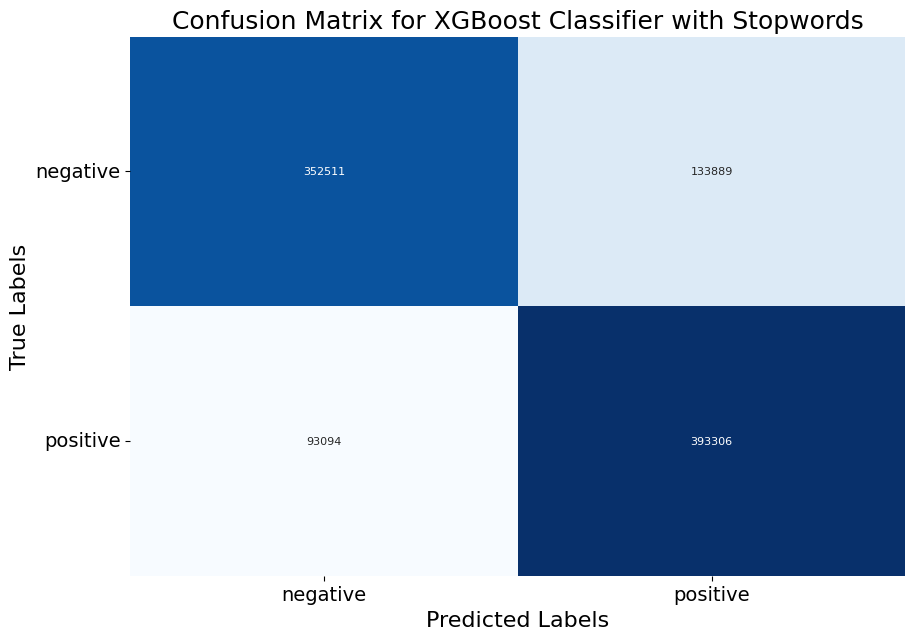

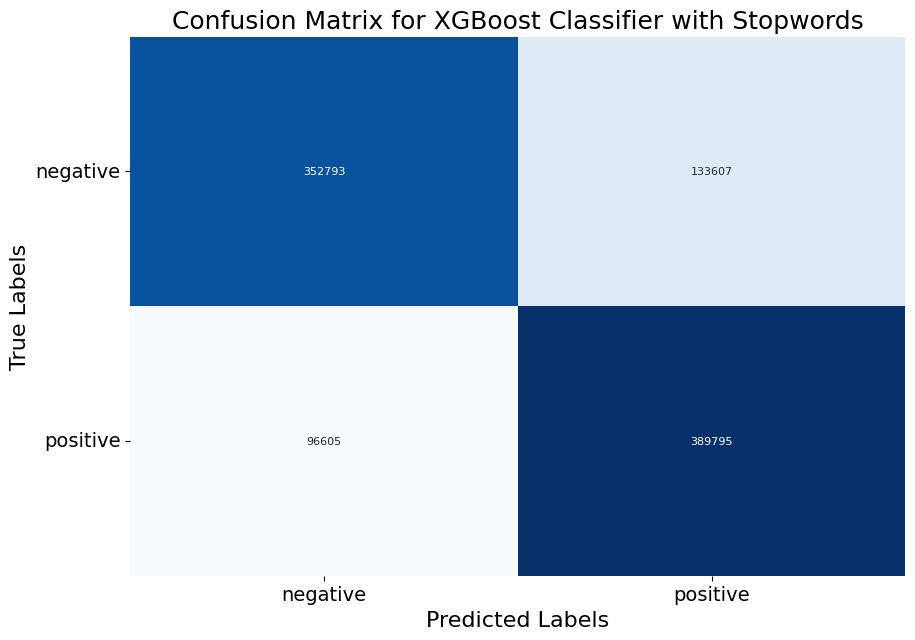

In [19]:
cm_nb = confusion_matrix(Y_train_stop, predictions_stop)


# creation of the Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 8})
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix for XGBoost Classifier with Stopwords', fontsize=18)
plt.xticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14, rotation=0)
plt.show()

cm_nb = confusion_matrix(Y_train_stop, predictions_training)

# creation of the Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 8})
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix for XGBoost Classifier with Stopwords', fontsize=18)
plt.xticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14, rotation=0)
plt.show()


In [20]:
with open('XGBoost_with_stopwords.pkl', 'wb') as file:
    pickle.dump(model2, file)